In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load preprocessed monthly sales
monthly_sales_df = pd.read_csv('../data/processed/monthly_sales.csv')
monthly_sales_df['month'] = pd.to_datetime(monthly_sales_df['month'])

# Preview
monthly_sales_df.head()


,month,shop_id,item_id,item_cnt_month
0,2013-01-01,0,32,6.0
1,2013-01-01,0,33,3.0
2,2013-01-01,0,35,1.0
3,2013-01-01,0,43,1.0
4,2013-01-01,0,51,2.0


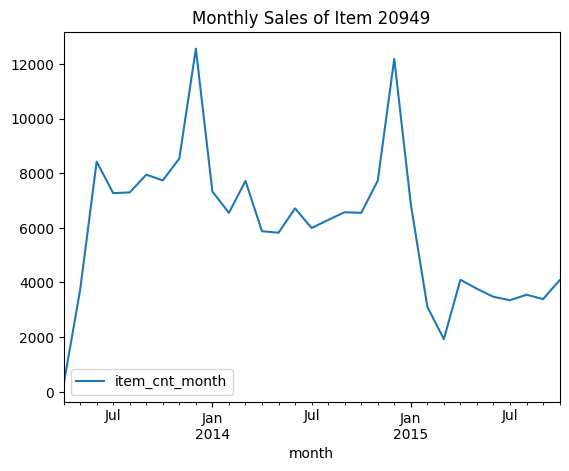

In [3]:
# Top item by total sales
top_item_id = monthly_sales_df.groupby('item_id')['item_cnt_month'].sum().sort_values(ascending=False).index[0]

# Filter data for that item
item_data = monthly_sales_df[monthly_sales_df['item_id'] == top_item_id]
item_data = item_data.groupby('month')['item_cnt_month'].sum().reset_index()

# Ensure continuity in months
item_data = item_data.set_index('month').asfreq('MS').fillna(0)

# Plot
item_data.plot(title=f'Monthly Sales of Item {top_item_id}')
plt.show()


In [4]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(item_data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # past 12 months
X, y = create_sequences(scaled_data, seq_length)

# Train/Test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [5]:
# Build model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2433 - val_loss: 0.0691
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2294 - val_loss: 0.0630
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2158 - val_loss: 0.0571
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2027 - val_loss: 0.0516
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1900 - val_loss: 0.0464
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1777 - val_loss: 0.0413
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1659 - val_loss: 0.0364
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1544 - val_loss: 0.0316
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 0.1431 - val_loss: 0.0269
Epoch 10/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1319 - val_loss: 0.0224
Epoch 11/100
1/1 [===

1/1 [==============================] - 0s 320ms/step


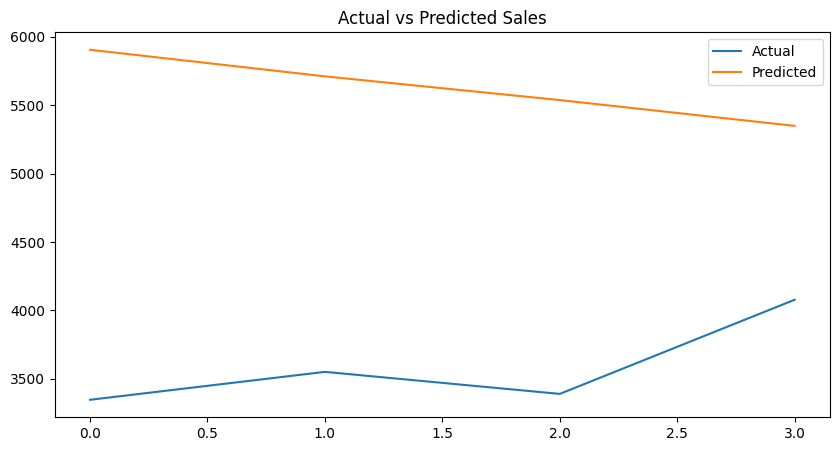

RMSE: 2087.56, MAE: 2033.85


In [6]:
# Predict
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')


In [7]:
# Save model and scaler
model.save('../models/lstm_model.h5')

import joblib
joblib.dump(scaler, '../models/scaler.save')


['../models/scaler.save']

In [8]:
# Predict next month
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, 1))
next_month_pred = model.predict(last_sequence)
next_month_pred_inv = scaler.inverse_transform(next_month_pred)
print(f'Predicted demand for next month: {next_month_pred_inv[0][0]:.2f}')


1/1 [==============================] - 0s 32ms/step
Predicted demand for next month: 5219.08
